# ADS 509 Final Team Project

### Jessica Hin, Halee Staggs, Vicky van der Wagt

----------------------------------------------------------------------------------

# Call Data from Clinicaltrial.gov API

In [247]:
# Import libraries
import requests
import json
import os
import datetime
import re
import time
import warnings

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import shutil
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.metrics import specificity_score, sensitivity_score
import nltk
from nltk.classify import NaiveBayesClassifier

# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, message="is_sparse is deprecated")

# Define figure parameters (feel free to change)
custom_palette = {'FEMALE': '#80ff80', 'MALE': '#99ccff'}
sns.set_style("darkgrid")
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

### Do a Test Call to API to check for bugs

In [2]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL) AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 5  # Limit to 5 records for testing
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Fetch the data and print it to test the connection
data = fetch_clinical_trials(params)

# Check if data was retrieved successfully
if data:
    # Print the JSON data
    print(json.dumps(data, indent=2))
else:
    print("No data retrieved or error occurred.")



Request URL: https://clinicaltrials.gov/api/v2/studies?format=json&postFilter.overallStatus=COMPLETED&postFilter.advanced=%28AREA%5BStudyType%5DINTERVENTIONAL+OR+OBSERVATIONAL%29+AND+%28AREA%5BSex%5DMALE+OR+AREA%5BSex%5DFEMALE%29&fields=NCTId%7CCondition%7CStartDate%7CPrimaryCompletionDate%7CBriefSummary%7CEnrollmentCount%7CSex%7CMinimumAge%7CMaximumAge&pageSize=5
{
  "studies": [
    {
      "protocolSection": {
        "identificationModule": {
          "nctId": "NCT01775462"
        },
        "statusModule": {
          "startDateStruct": {
            "date": "2013-04"
          },
          "primaryCompletionDateStruct": {
            "date": "2015-12"
          }
        },
        "descriptionModule": {
          "briefSummary": "This Phase 2 first-in-neonate EDI200 study will enroll treatment-na\u00efve, XLHED-affected male newborns in the first two weeks of life. All subjects will meet entry criteria including documentation of an Ectodysplasin (EDA) mutation associated with 

## Run full call to API

In [135]:
# Define the base URL for the API
base_url = "https://clinicaltrials.gov/api/v2/studies"

# Define the query parameters and desired fields
params = {
    'format': 'json',
    'postFilter.overallStatus': 'COMPLETED',
    'postFilter.advanced': '(AREA[StudyType]INTERVENTIONAL OR OBSERVATIONAL)',
    'fields': 'NCTId|Condition|StartDate|PrimaryCompletionDate|BriefSummary|EnrollmentCount|Sex|MinimumAge|MaximumAge',
    'pageSize': 1000  # Number of records to fetch per request
}

# Function to make the API call
def fetch_clinical_trials(params):
    try:
        response = requests.get(base_url, params=params, headers={"accept": "application/json"})
        # Print the final URL to debug any issues with the query parameters
        #print(f"Request URL: {response.url}")
        # Check if the request was successful
        if response.status_code == 200:
            print("API call successful")
            return response.json()
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

# Function to extract relevant data from the API response
def extract_study_data(study):
    protocol_section = study.get('protocolSection', {})
    identification_module = protocol_section.get('identificationModule', {})
    status_module = protocol_section.get('statusModule', {})
    description_module = protocol_section.get('descriptionModule', {})
    conditions_module = protocol_section.get('conditionsModule', {})
    design_module = protocol_section.get('designModule', {})
    eligibility_module = protocol_section.get('eligibilityModule', {})

    # Exclude records where sex or brief summary is not available
    if 'sex' not in eligibility_module or 'briefSummary' not in description_module:
        return None

    return {
        'NCTId': identification_module.get('nctId', 'N/A'),
        'Condition': conditions_module.get('conditions', ['N/A']),
        'StartDate': status_module.get('startDateStruct', {}).get('date', 'N/A'),
        'PrimaryCompletionDate': status_module.get('primaryCompletionDateStruct', {}).get('date', 'N/A'),
        'BriefSummary': description_module.get('briefSummary', 'N/A'),
        'EnrollmentCount': design_module.get('enrollmentInfo', {}).get('count', 'N/A'),
        'Sex': eligibility_module.get('sex', 'N/A'),
        'MinimumAge': eligibility_module.get('minimumAge', 'N/A'),
        'MaximumAge': eligibility_module.get('maximumAge', 'N/A')
    }

# Fetch and process the data with a delay between requests and avoid duplicates
def fetch_and_process_data(params, max_requests):  # Increase max_requests for full data retrieval
    all_extracted_data = []
    seen_nct_ids = set()
    next_page_token = None

    for _ in range(max_requests):
        if next_page_token:
            params['pageToken'] = next_page_token

        data = fetch_clinical_trials(params)
        if data:
            studies = data.get('studies', [])
            next_page_token = data.get('nextPageToken', None)

            print(f"Number of studies fetched: {len(studies)}")  # Debugging statement
            for study in studies:
                nct_id = study.get('protocolSection', {}).get('identificationModule', {}).get('nctId')
                if nct_id and nct_id not in seen_nct_ids:
                    seen_nct_ids.add(nct_id)
                    extracted_data = extract_study_data(study)
                    all_extracted_data.append(extracted_data)
                    #print(json.dumps(extracted_data, indent=2))  # Debugging statement
                else:
                    print(f"Duplicate or missing NCTId: {nct_id}")

            if not next_page_token:
                break  # No more pages to fetch

        # Pause the execution for a short, random period of time to avoid overwhelming the server
        time.sleep(5 + 10 * random.random())
    
    return all_extracted_data

# Fetch data for random sample of MALE or FEMALE studies
random_sample_params = params.copy()
random_sample_params['postFilter.advanced'] += ' AND (AREA[Sex]MALE OR AREA[Sex]FEMALE)'
random_sample_studies = fetch_and_process_data(random_sample_params, max_requests=15)

# Combine both sets of data
all_data = random_sample_studies 

# Save the data to a file in repository to avoid sending request to server
with open('clinical_trials.json', 'w') as outfile:
    json.dump(all_data, outfile, indent=2)

print("Data fetching and processing complete.")

API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
API call successful
Number of studies fetched: 1000
Data fetching and processing complete.


## Examine Data

In [156]:
# Convert the extracted data to a DataFrame
all_df = pd.DataFrame(all_data)
# Save DataFrame to a CSV file
all_df.to_csv('clinical_trials.csv', index=False)

# Start New File Here: EDA

### Read in .csv file of data 

In [157]:
all_df = pd.read_csv(r"clinical_trials.csv")

In [158]:
# Dataframe shape
all_df.shape

(15000, 9)

In [159]:
# Display the DataFrame
all_df.head(), all_df.tail()

(         NCTId                                          Condition   StartDate  \
 0  NCT05559840                         ['Post Partum Hemorrhage']  2017-01-01   
 1  NCT00688740                                  ['Breast Cancer']     1997-06   
 2  NCT01757340  ['Obesity', 'Menopause', 'Osteoporosis', 'Sarc...     2012-09   
 3  NCT04993040                                   ['Breastcancer']  2019-04-22   
 4  NCT01418040                                ['Prostate Cancer']  2012-11-28   
 
   PrimaryCompletionDate                                       BriefSummary  \
 0            2019-12-31  A Randomized Controlled Non inferiority Trial ...   
 1               2010-01  The purpose of this study was to compare disea...   
 2               2017-03  The purpose of this study is to determine whet...   
 3            2019-12-09  This is a multicenter, open-label, single-arm ...   
 4            2017-07-20  This is a single centre prospective observatio...   
 
    EnrollmentCount     Sex Mi

In [160]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NCTId                  15000 non-null  object 
 1   Condition              15000 non-null  object 
 2   StartDate              14884 non-null  object 
 3   PrimaryCompletionDate  14324 non-null  object 
 4   BriefSummary           15000 non-null  object 
 5   EnrollmentCount        14780 non-null  float64
 6   Sex                    15000 non-null  object 
 7   MinimumAge             14160 non-null  object 
 8   MaximumAge             9938 non-null   object 
dtypes: float64(1), object(8)
memory usage: 1.0+ MB


# Preprocess All Data + EDA
    * Examine and handle missing values
    * Fix column datatypes
    * Feature creation

### Examine and Handle Missing Values

First handle missing values within the dataframe in preparation for plotting. 

In [161]:
# Count missing values (NaN) in each column
na_counts = all_df.isna().sum()
total_records = len(all_df)
percentage_na = (na_counts / total_records)

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Missing Proportion': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

print("DataFrame with counts and percentages of missing (NaN) values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='grid'))

DataFrame with counts and percentages of missing (NaN) values:
+----+-----------------------+-----------------+----------------------+
|    | Column                |   Missing Count |   Missing Proportion |
+====+=======================+=================+======================+
|  0 | NCTId                 |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  1 | Condition             |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|  2 | StartDate             |             116 |           0.00773333 |
+----+-----------------------+-----------------+----------------------+
|  3 | PrimaryCompletionDate |             676 |           0.0450667  |
+----+-----------------------+-----------------+----------------------+
|  4 | BriefSummary          |               0 |           0          |
+----+-----------------------+-----------------+----------------------+
|

A new df "no_nans" was created in order to do EDA - this is to seperate it from all the preprocessing step when splitting the data into train and test dataframes.

In [162]:
# Missing values to null for now (simplifies type conversions & plotting)
def na_to_null(df, column):
    """This function replaces "N/A" values in a df column with null"""
    df[column] = df[column].replace('N/A', np.nan)
    return df

no_nans = na_to_null(all_df, ['PrimaryCompletionDate', 'StartDate','EnrollmentCount','MinimumAge', 'MaximumAge'])

### Feature Clean-up, Feature Creation

New columns "MinimumAgeYrs" and "MaximumAgeYrs" are created to change all the values that are less than a year to 0.

In [163]:
# Extract years from age feature
def extract_years(age_feature):
    """This function converts age features to years. If the feature
    does not contain "Year" or "Years", needs to be 0 years. """
    # Check if the input value is already numeric
    if isinstance(age_feature, (int, float)):
        return age_feature
    # If not numeric, split text
    parts = age_feature.split()
    # If unit is Year or Years, return number before the unit
    if parts[1] == 'Years' or parts[1] == 'Year':
        return int(parts[0])
    # Else return 0 years (anything other than year is less than a year (weeks, months, etc))
    return 0

#convert age features to numerical
no_nans['MinimumAgeYrs'] = no_nans['MinimumAge'].apply(extract_years)
no_nans['MaximumAgeYrs'] = no_nans['MaximumAge'].apply(extract_years)

# Convert StartDate PrimaryCompletionDate column to date type
no_nans['StartDate'] = pd.to_datetime(no_nans['StartDate'], errors='coerce')
no_nans['PrimaryCompletionDate'] = pd.to_datetime(no_nans['PrimaryCompletionDate'], errors='coerce')

# Generate Year and Month columns 
no_nans['StartYear'] = no_nans['StartDate'].dt.year
no_nans['StartMonth'] = no_nans['StartDate'].dt.month
no_nans['StartDecade'] = (no_nans['StartYear'] // 10) * 10

# Generate Column for Number of Conditions
no_nans['ConditionCount'] = no_nans['Condition'].apply(len)

# Generate Column for study Duration
no_nans['Duration'] = (no_nans['PrimaryCompletionDate'] - no_nans['StartDate']).dt.days
no_nans['DurationYrsRounded'] = (no_nans['Duration'] / 365).round(2)

no_nans.head()

,NCTId,Condition,StartDate,PrimaryCompletionDate,BriefSummary,EnrollmentCount,Sex,MinimumAge,MaximumAge,MinimumAgeYrs,MaximumAgeYrs,StartYear,StartMonth,StartDecade,ConditionCount,Duration,DurationYrsRounded
0,NCT05559840,['Post Partum Hemorrhage'],2017-01-01,2019-12-31,A Randomized Controlled Non inferiority Trial ...,82.0,FEMALE,18 Years,49 Years,18.0,49.0,2017.0,1.0,2010.0,26,1094.0,3.00
1,NCT00688740,['Breast Cancer'],NaT,NaT,The purpose of this study was to compare disea...,1491.0,FEMALE,18 Years,70 Years,18.0,70.0,NaN,NaN,NaN,17,NaN,NaN
2,NCT01757340,"['Obesity', 'Menopause', 'Osteoporosis', 'Sarc...",NaT,NaT,The purpose of this study is to determine whet...,43.0,FEMALE,50 Years,65 Years,50.0,65.0,NaN,NaN,NaN,54,NaN,NaN
3,NCT04993040,['Breastcancer'],2019-04-22,2019-12-09,"This is a multicenter, open-label, single-arm ...",24.0,FEMALE,18 Years,NaN,18.0,NaN,2019.0,4.0,2010.0,16,231.0,0.63
4,NCT01418040,['Prostate Cancer'],2012-11-28,2017-07-20,This is a single centre prospective observatio...,28.0,MALE,NaN,NaN,NaN,NaN,2012.0,11.0,2010.0,19,1695.0,4.64


In [188]:
# Combine "condition" description with "brief summary" description
no_nans['all_text'] = no_nans['Condition']+no_nans['BriefSummary']

In [189]:
no_nans['all_text'].head()

0    ['Post Partum Hemorrhage']A Randomized Control...
1    ['Breast Cancer']The purpose of this study was...
2    ['Obesity', 'Menopause', 'Osteoporosis', 'Sarc...
3    ['Breastcancer']This is a multicenter, open-la...
4    ['Prostate Cancer']This is a single centre pro...
Name: all_text, dtype: object

# EDA of Data Other than Brief Summary

Let's first see how many different studies there are.

In [164]:
no_nans['Condition'].value_counts()

Condition
['Healthy']                                                                        855
['Breast Cancer']                                                                  673
['Prostate Cancer']                                                                515
['Infertility']                                                                    171
['Healthy Volunteers']                                                             154
                                                                                  ... 
['Parenting', 'Mother-child Relations']                                              1
['Subfertility', 'Anovulatory', 'Obese']                                             1
['Vaginal Laxity Following Childbirth', 'Sexual Function Following Childbirth']      1
['Carcinoma, Renal Cell', 'Kidney Disease', 'Kidney Cancer']                         1
['BPH', 'Lower Urinary Tract Symptoms']                                              1
Name: count, Length: 7431, dtype:

There are 7,417 different conditions that a person can possibly be in this dataframe. "Healthy" is amongst the most common conditions, we might need to consider only classifying for the top 5 conditions otherwise the counts are really low. 

In [165]:
# Gender stats
no_nans['Sex'].value_counts()

Sex
FEMALE    9590
MALE      5410
Name: count, dtype: int64

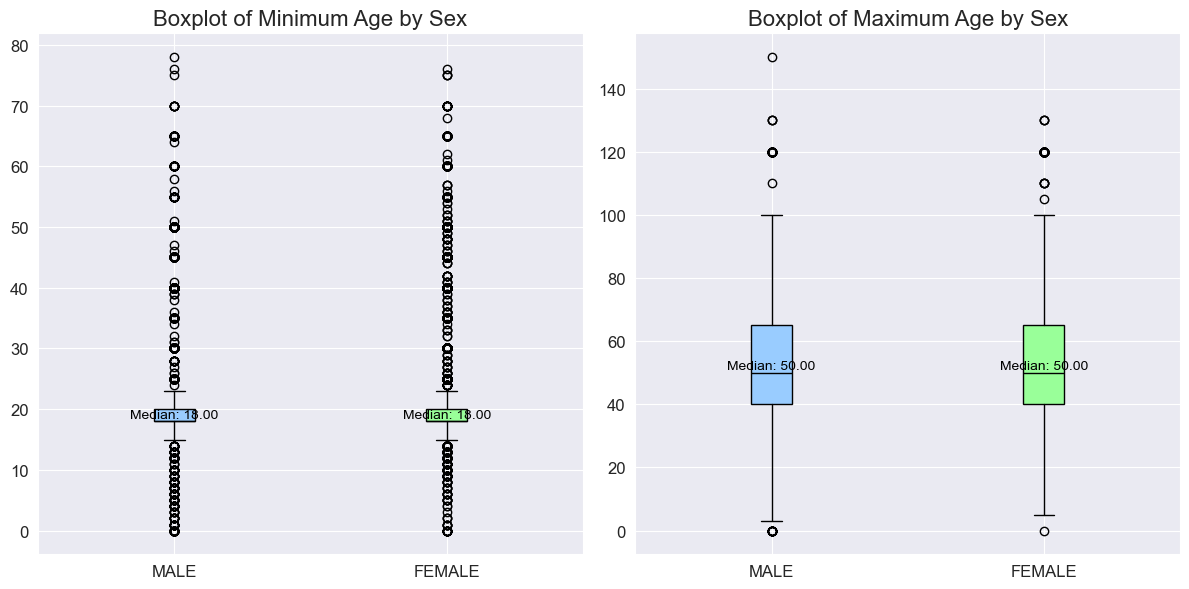

In [11]:
# Age stats by sex
import matplotlib.pyplot as plt

def plot_boxplot(data, column, ax, title, custom_palette):
    """Function to plot boxplots for a specific column, with annotations for male and female data"""
    # Filter data by sex
    data_male = data[data['Sex'] == 'MALE'][column].dropna()
    data_female = data[data['Sex'] == 'FEMALE'][column].dropna()
    
    # Plot boxplots
    male_boxes = ax.boxplot(data_male, positions=[1], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['MALE']))
    female_boxes = ax.boxplot(data_female, positions=[2], patch_artist=True, medianprops=dict(color='black'), boxprops=dict(facecolor=custom_palette['FEMALE']))
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['MALE', 'FEMALE'])
    
    # Annotate median values for male and female data
    male_median = male_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {male_median:.2f}', xy=(1, male_median), xytext=(1, male_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')
    
    female_median = female_boxes['medians'][0].get_ydata()[0]
    ax.annotate(f'Median: {female_median:.2f}', xy=(2, female_median), xytext=(2, female_median + 0.1), ha='center', va='bottom', fontsize=10, color='black')

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define palette
custom_palette = {'FEMALE': '#99ff99', 'MALE': '#99ccff'} 

# Boxplot for MinimumAgeYrs
plot_boxplot(all_df, 'MinimumAgeYrs', axes[0], 'Boxplot of Minimum Age by Sex', custom_palette)

# Boxplot for MaximumAgeYrs
plot_boxplot(all_df, 'MaximumAgeYrs', axes[1], 'Boxplot of Maximum Age by Sex', custom_palette)

# Show plot
plt.tight_layout()
plt.show()



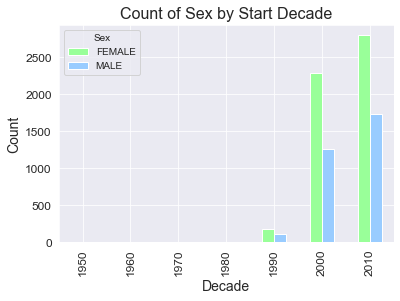

In [40]:
# Date stats by sex

#Could also do by year if desired
counts = no_nans.groupby(['StartDecade', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Count of Sex by Start Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Sex')
 
# Show plot
plt.show()


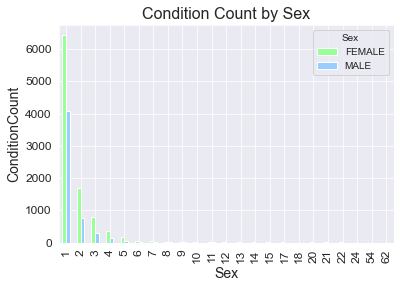

In [41]:
# Number of conditions by sex

counts = no_nans.groupby(['ConditionCount', 'Sex']).size().unstack(fill_value=0)

counts.index = counts.index.astype(int)

ax = counts.plot(kind='bar', stacked=False, color=custom_palette)

# Add labels and title
plt.title('Condition Count by Sex')
plt.xlabel('Sex')
plt.ylabel('ConditionCount')
 
# Show plot
plt.show()


In [42]:
# Enrollment Numbers by Sex

# Get descriptive statistics
enrollment_stats = no_nans.groupby('Sex')['EnrollmentCount'].describe()

# Round statistics to whole numbers
rounded_enrollment_stats = enrollment_stats.astype(int)

# Display table with title
print("Enrollment Statistics by Sex:\n")
print(tabulate(rounded_enrollment_stats, headers=rounded_enrollment_stats.columns, tablefmt='pretty'))

Enrollment Statistics by Sex:

+--------+-------+------+------+-----+-----+-----+-----+--------+
|        | count | mean | std  | min | 25% | 50% | 75% |  max   |
+--------+-------+------+------+-----+-----+-----+-----+--------+
| FEMALE | 9491  | 604  | 7075 |  0  | 40  | 80  | 190 | 430830 |
|  MALE  | 5279  | 130  | 791  |  0  | 18  | 34  | 71  | 35533  |
+--------+-------+------+------+-----+-----+-----+-----+--------+


In [43]:
# Study Duration by Sex (rounded to closest # of years)

# Get descriptive statistics
duration_stats = no_nans.groupby('Sex')['DurationYrsRounded'].describe()

# Round statistics to whole numbers
rounded_duration_stats = round(duration_stats,2)

# Display table with title
print("Enrollment Statistics by Sex:\n")
print(tabulate(rounded_duration_stats, headers=rounded_duration_stats.columns, tablefmt='pretty'))

Enrollment Statistics by Sex:

+--------+--------+------+------+-----+------+------+------+-------+
|        | count  | mean | std  | min | 25%  | 50%  | 75%  |  max  |
+--------+--------+------+------+-----+------+------+------+-------+
| FEMALE | 4537.0 | 2.58 | 2.25 | 0.0 | 1.0  | 2.0  | 3.5  | 21.27 |
|  MALE  | 2780.0 | 1.67 | 2.45 | 0.0 | 0.25 | 0.83 | 2.33 | 46.95 |
+--------+--------+------+------+-----+------+------+------+-------+


## Train/Test Split

In [190]:
# Split the DataFrame into features (X) and target variable (y)
y = no_nans['Sex']
X = no_nans.drop(['Sex'],axis = 1)  # Features
                   # Target variable

# Step 1: Encode the categorical response variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Now, we can get what the label encoded each class to be.

In [191]:
# Retrieve the mapping between original labels and encoded values
label_mapping = {label: encoded_value for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

print("Label mapping:")
print(label_mapping)

Label mapping:
{'FEMALE': 0, 'MALE': 1}


In order to resample, I can't use smote as we hae non-numeric and categorical variables. But, we can manually do it. The X_train and y_train have to be put back together in order to resample.

In [192]:
# Create a synthetic DataFrame
y_train = pd.DataFrame(y_train)
y_train = y_train.rename(columns = {0:'Sex'})
temp_df = pd.concat([X_train, y_train], axis=1)

In [193]:
# Drop values of NaN for brieft summaries
temp_df = temp_df.dropna(subset=['BriefSummary'])

In [194]:
# Display class distribution
print("Original class distribution:")
print(temp_df['Sex'].value_counts())

Original class distribution:
Sex
0.0    6131
1.0    3461
Name: count, dtype: int64


## Oversampling method

In [16]:
# Now we move on to resampling
# Separate minority and majority classes
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the majority class
majority_count = len(majority_class)

# Sample from the minority class with replacement to match the number of samples in the majority class
minority_resampled = minority_class.sample(n=majority_count, replace=True, random_state=42)

# Combine the resampled minority class with the original majority class
resampled_df = pd.concat([majority_class, minority_resampled])

# Shuffle the dataframe
resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nResampled class distribution:")
print(resampled_df['Sex'].value_counts())



Resampled class distribution:
Sex
0.0    7728
1.0    7728
Name: count, dtype: int64


In [17]:
resampled_df.head()

,NCTId,Condition,StartDate,PrimaryCompletionDate,BriefSummary,EnrollmentCount,MinimumAge,MaximumAge,MinimumAgeYrs,MaximumAgeYrs,StartYear,StartMonth,StartDecade,ConditionCount,Duration,DurationYrsRounded,Sex
0,NCT00534274,['Breast Cancer'],2006-11-01,2012-04-01,"RATIONALE: Diagnostic procedures, such as posi...",97.0,18 Years,65 Years,18.0,65.0,2006.0,11.0,2000.0,17.0,1978.0,5.42,0.0
1,NCT00665860,['Osteoporosis'],2001-04-01,2006-06-01,The purpose of this study is to determine whet...,403.0,40 Years,60 Years,40.0,60.0,2001.0,4.0,2000.0,16.0,1887.0,5.17,1.0
2,NCT00452673,['Advanced Breast Cancer'],2007-06-01,2012-10-01,The purpose of this study is to learn about th...,52.0,18 Years,NaN,18.0,NaN,2007.0,6.0,2000.0,26.0,1949.0,5.34,0.0
3,NCT02142127,['Healthy'],2014-04-01,2014-06-01,Human mass-balance studies with radiolabelled ...,6.0,55 Years,65 Years,55.0,65.0,2014.0,4.0,2010.0,11.0,61.0,0.17,1.0
4,NCT03956082,['Endometriosis'],NaT,NaT,This is a prospective single arm study. The st...,15.0,18 Years,NaN,18.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,0.0


## Undersampling method

In [195]:
# Separate minority and majority classes
minority_class = temp_df[temp_df['Sex'] == 1]
majority_class = temp_df[temp_df['Sex'] == 0]

# Determine the number of samples in the minority class
minority_count = len(minority_class)

# Sample from the majority class without replacement to match the number of samples in the minority class
majority_resampled = majority_class.sample(n=minority_count, replace=False, random_state=42)

# Combine the resampled majority class with the original minority class
resampled_df = pd.concat([minority_class, majority_resampled])

# Shuffle the dataframe
resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display resampled class distribution
print("\nResampled class distribution:")
print(resampled_df['Sex'].value_counts())


Resampled class distribution:
Sex
1.0    3461
0.0    3461
Name: count, dtype: int64


In [199]:
resampled_df.head()

,NCTId,Condition,StartDate,PrimaryCompletionDate,BriefSummary,EnrollmentCount,MinimumAge,MaximumAge,MinimumAgeYrs,MaximumAgeYrs,StartYear,StartMonth,StartDecade,ConditionCount,Duration,DurationYrsRounded,all_text,Sex,ProcessedSummary
0,NCT00807404,['Precancerous Condition'],NaT,NaT,"RATIONALE: New diagnostic procedures, such as ...",50.0,18 Years,NaN,18.0,NaN,NaN,NaN,NaN,26.0,NaN,NaN,['Precancerous Condition']RATIONALE: New diagn...,1.0,"[rationale, new, diagnostic, procedures, optic..."
1,NCT04385680,"['Postpartum Endometritis', 'Wound Infection',...",2020-05-15,2022-03-10,The study aims to assess the beneficial value ...,840.0,18 Years,NaN,18.0,NaN,2020.0,5.0,2020.0,103.0,664.0,1.82,"['Postpartum Endometritis', 'Wound Infection',...",1.0,"[study, aims, assess, beneficial, value, vagin..."
2,NCT06227676,"['Dysmenorrhea Primary', 'Dysmenorrhea', 'Mens...",2022-07-21,2022-09-15,85 percent of women of reproductive age experi...,12.0,18 Years,25 Years,18.0,25.0,2022.0,7.0,2020.0,453.0,56.0,0.15,"['Dysmenorrhea Primary', 'Dysmenorrhea', 'Mens...",1.0,"[85, percent, women, reproductive, age, experi..."
3,NCT03329989,"['Edematous Fibrosclerotic Panniculopathy', 'C...",2017-11-17,2018-09-05,An open-label study of safety and effectivenes...,158.0,18 Years,NaN,18.0,NaN,2017.0,11.0,2010.0,56.0,292.0,0.80,"['Edematous Fibrosclerotic Panniculopathy', 'C...",1.0,"[openlabel, study, safety, effectiveness, en38..."
4,NCT00183820,"['Testicular Cancer', 'Germ Cell Neoplasm']",NaT,NaT,This is a study for patients with advanced tes...,30.0,16 Years,NaN,16.0,NaN,NaN,NaN,NaN,43.0,NaN,NaN,"['Testicular Cancer', 'Germ Cell Neoplasm']Thi...",0.0,"[study, patients, advanced, testicular, cancer..."


# Apply Preprocessing Steps to Brief Summary Text Data

In [200]:
sw = stopwords.words("english")
punctuation = set(punctuation)

def remove_stopwords(tokens) :
    """This function removes stopwords (sw) from text"""
    
    tokens = [token for token in tokens if token not in sw]
    
    return(tokens)

def tokenize(text) : 
    """ This function splits text on whitespace. """
    text = text.split()
    return(text)

def remove_punctuation(text, punct_set=punctuation) : 
    
    return("".join([ch for ch in text if ch not in punctuation]))

def process_text(text, pipeline):
    if pd.isnull(text):  # Check if text is NaN
        return text  # Return NaN without processing
    else:
        for function in pipeline:
            text = function(text)
        return text

summary_pipeline = [str.lower, remove_punctuation, tokenize, remove_stopwords]


# Save as new column, ProcessedSummmary for analysis
resampled_df['ProcessedSummary'] = resampled_df['all_text'].apply(lambda x: process_text(x, summary_pipeline))


In [201]:
resampled_df.shape, resampled_df['Sex'].value_counts()

((6922, 19),
 Sex
 1.0    3461
 0.0    3461
 Name: count, dtype: int64)

### Examine Clean Tokens

In [202]:
resampled_df['ProcessedSummary'].head(25)

0     [precancerous, conditionrationale, new, diagno...
1     [postpartum, endometritis, wound, infection, c...
2     [dysmenorrhea, primary, dysmenorrhea, menstrua...
3     [edematous, fibrosclerotic, panniculopathy, ce...
4     [testicular, cancer, germ, cell, neoplasmthis,...
5     [indications, laparoscopic, supracervical, hys...
6     [female, infertilitycomparison, group, treated...
7     [pharmacokineticsthis, study, designed, assess...
8     [contraceptionthis, observational, study, asse...
9     [drugs, abusethe, phase, evaluation, intended,...
10    [high, risk, pregnancypregnancies, resulting, ...
11    [labor, paincomparison, three, programmed, int...
12    [benign, prostatic, hyperplasiarandomized, dou...
13    [healthythe, foods, eaten, daily, considered, ...
14    [labor, prolonged, second, stage, episiotomy, ...
15    [breast, neoplasmskinases, group, proteins, im...
16    [breast, cancerthe, combination, pecs, ii, par...
17    [vaginal, diseasesthis, project, aims, stu

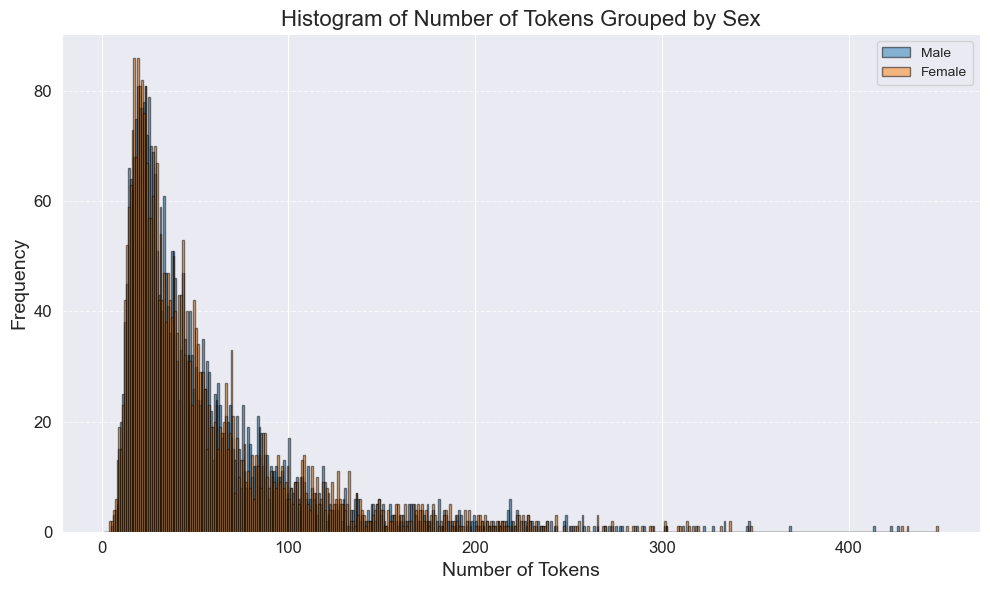

In [203]:
# Distribution of Number of Tokens by Sex
# Count the number of tokens in each list
# Function to count tokens in a list
def count_tokens(token_list):
    if isinstance(token_list, list):
        return len(token_list)
    else:
        return 0  
        
resampled_df['num_tokens'] = resampled_df['ProcessedSummary'].apply(count_tokens)

# Group by 'sex' and plot histogram
male_tokens = resampled_df[resampled_df['Sex'] == 1]['num_tokens']
female_tokens = resampled_df[resampled_df['Sex'] == 0]['num_tokens']

plt.figure(figsize=(10, 6))

plt.hist(male_tokens, bins=range(1, max(resampled_df['num_tokens']) + 2), alpha=0.5, label='Male', edgecolor='black')
plt.hist(female_tokens, bins=range(1, max(resampled_df['num_tokens']) + 2), alpha=0.5, label='Female', edgecolor='black')

plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens Grouped by Sex')
plt.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Descriptive Stats of Text Data

In [124]:
# I had to rewrite the descriptive_stats function in order to read in the nested list of words.
def new_descriptive_stats(tokens, num_tokens = 5 , verbose=True) :

    # Fill in the correct values here. 
    flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    total_tokens = len(flat_tokens)  # total number of tokens
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:11] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The ten most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

## Female descriptives

In [204]:
new_descriptive_stats(resampled_df[resampled_df['Sex'] == 0]['ProcessedSummary'])

There are 196114 tokens in the data.
There are 20673 unique tokens in the data.
There are 1428404 characters in the data.
The lexical diversity is 0.105 in the data.
The ten most common tokens are [('study', 3680), ('cancer', 1559), ('women', 1559), ('patients', 1523), ('treatment', 1257), ('breast', 1120), ('group', 812), ('purpose', 791), ('trial', 786), ('pain', 736), ('evaluate', 734)] in the data.


[196114, 20673, 0.10541317804950182, 1428404]

## Male descriptives

In [205]:
new_descriptive_stats(resampled_df[resampled_df['Sex'] == 1]['ProcessedSummary'])

There are 196347 tokens in the data.
There are 20309 unique tokens in the data.
There are 1431767 characters in the data.
The lexical diversity is 0.103 in the data.
The ten most common tokens are [('study', 3647), ('cancer', 1660), ('women', 1578), ('patients', 1359), ('treatment', 1211), ('breast', 1203), ('purpose', 790), ('trial', 782), ('may', 687), ('healthy', 678), ('group', 678)] in the data.


[196347, 20309, 0.10343422614045542, 1431767]

# Further processing of tokens

#### Preprocessing for SVM using tfidf

In [104]:
# Function to safely join tokens into a string
def safe_join(token_list):
    if isinstance(token_list, list):
        return ' '.join(token_list)
    return ''

In [206]:
# Convert lists of tokens into string vectors
resampled_df['vectors'] = resampled_df['ProcessedSummary'].apply(safe_join)

In [207]:
# Apply TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.1)
resampled_tfidf = tfidf.fit_transform(resampled_df['vectors'])

In [208]:
# Print the resulting TF-IDF matrix
#print(resampled_tfidf.toarray()[0:2])
print(resampled_tfidf.data.nbytes)

2068144


In [209]:
#np.set_printoptions(threshold=np.inf)
#print(resampled_tfidf.toarray()[0])

In [210]:
resampled_tfidf.shape

(6922, 30291)

### Preprocessing for Naive Bayes 

In [261]:
# Function to get all tokens from the DataFrame
def get_all_tokens(df):
    return [token for sublist in df['ProcessedSummary'] for token in sublist]

# Get all tokens
all_tokens = get_all_tokens(resampled_df)

# Create frequency distribution for all tokens
word_dist = nltk.FreqDist(all_tokens)

# Define a word frequency cutoff
word_cutoff = 10  # Adjust this based on your data

# Collect words that appear at least word_cutoff times
feature_words = {word for word, count in word_dist.items() if count >= word_cutoff}

# Make into dataframe
feature_words_df = pd.DataFrame(list(feature_words), columns=['feature_word'])

# Look at top words
print("Top words:")
print(feature_words_df)

Top words:
         feature_word
0                 240
1             focused
2     lymphadenectomy
3              peanut
4          singledose
...               ...
4600          promise
4601       continence
4602             open
4603           median
4604        adversely

[4605 rows x 1 columns]


In [262]:
# Create function to identify if speeches contain the feature words identified above
def conv_features(text, fw) :
    # Initialize an empty dictionary to hold the feature words
    ret_dict = []
    
    # Iterate over the words in the list
    for word in text:
        # If the word is in the feature words set and not already in the dictionary
        if word in fw and word not in ret_dict:
            # Add the word to the dictionary with the value True
            ret_dict.append(word)
    return ret_dict

# Apply the function to the DataFrame
resampled_df['feature_words'] = resampled_df['ProcessedSummary'].apply(lambda x: conv_features(x, feature_words))

In [263]:
resampled_df['feature_words'].head()

0    [precancerous, new, diagnostic, procedures, co...
1    [postpartum, endometritis, wound, infection, c...
2    [dysmenorrhea, primary, menstrual, discomfort,...
3    [edematous, fibrosclerotic, openlabel, study, ...
4    [testicular, cancer, germ, cell, study, patien...
Name: feature_words, dtype: object

In [243]:
resampled_df.head()

,NCTId,Condition,StartDate,PrimaryCompletionDate,BriefSummary,EnrollmentCount,MinimumAge,MaximumAge,MinimumAgeYrs,MaximumAgeYrs,...,StartDecade,ConditionCount,Duration,DurationYrsRounded,all_text,Sex,ProcessedSummary,num_tokens,vectors,feature_words
0,NCT00807404,['Precancerous Condition'],NaT,NaT,"RATIONALE: New diagnostic procedures, such as ...",50.0,18 Years,NaN,18.0,NaN,...,NaN,26.0,NaN,NaN,['Precancerous Condition']RATIONALE: New diagn...,1.0,"[precancerous, conditionrationale, new, diagno...",31,precancerous conditionrationale new diagnostic...,"[new, diagnostic, procedures, tomography, may,..."
1,NCT04385680,"['Postpartum Endometritis', 'Wound Infection',...",2020-05-15,2022-03-10,The study aims to assess the beneficial value ...,840.0,18 Years,NaN,18.0,NaN,...,2020.0,103.0,664.0,1.82,"['Postpartum Endometritis', 'Wound Infection',...",1.0,"[postpartum, endometritis, wound, infection, c...",33,postpartum endometritis wound infection chlorh...,"[postpartum, wound, infection, adverse, reacti..."
2,NCT06227676,"['Dysmenorrhea Primary', 'Dysmenorrhea', 'Mens...",2022-07-21,2022-09-15,85 percent of women of reproductive age experi...,12.0,18 Years,25 Years,18.0,25.0,...,2020.0,453.0,56.0,0.15,"['Dysmenorrhea Primary', 'Dysmenorrhea', 'Mens...",1.0,"[dysmenorrhea, primary, dysmenorrhea, menstrua...",94,dysmenorrhea primary dysmenorrhea menstrual di...,"[dysmenorrhea, primary, menstrual, discomfort,..."
3,NCT03329989,"['Edematous Fibrosclerotic Panniculopathy', 'C...",2017-11-17,2018-09-05,An open-label study of safety and effectivenes...,158.0,18 Years,NaN,18.0,NaN,...,2010.0,56.0,292.0,0.80,"['Edematous Fibrosclerotic Panniculopathy', 'C...",1.0,"[edematous, fibrosclerotic, panniculopathy, ce...",13,edematous fibrosclerotic panniculopathy cellul...,"[openlabel, study, safety, effectiveness, trea..."
4,NCT00183820,"['Testicular Cancer', 'Germ Cell Neoplasm']",NaT,NaT,This is a study for patients with advanced tes...,30.0,16 Years,NaN,16.0,NaN,...,NaN,43.0,NaN,NaN,"['Testicular Cancer', 'Germ Cell Neoplasm']Thi...",0.0,"[testicular, cancer, germ, cell, neoplasmthis,...",38,testicular cancer germ cell neoplasmthis study...,"[testicular, cancer, germ, cell, study, patien..."


# Model Training and Testing

## Preliminary SVM Model: Poor performance but does better predicting FEMALE than MALE

In [211]:
svm_model = LinearSVC(random_state = 1, tol = 1e-5)
svm_model.fit(resampled_tfidf, resampled_df['Sex'])

C:\Users\halee\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=1, tol=1e-05)

## Apply preprocessing steps to test set

In [249]:
# Convert lists of tokens into strings
X_test['ProcessedSummary'] = X_test['BriefSummary'].apply(lambda x: process_text(x, summary_pipeline))
X_test['vectors'] = X_test['ProcessedSummary'].apply(safe_join)
X_test_tfidf = tfidf.transform(X_test['vectors'])
y_pred = svm_model.predict(X_test_tfidf)

In [250]:
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision Score:', precision_score(y_test, y_pred))
print('Recall Score:', recall_score(y_test, y_pred))
print('Sensitivity Score:', sensitivity_score(y_test, y_pred))
print('Specificity Score:', specificity_score(y_test, y_pred))

Accuracy Score: 0.5046666666666667
Precision Score: 0.3709893048128342
Recall Score: 0.5045454545454545
Sensitivity Score: 0.5045454545454545
Specificity Score: 0.5047368421052632


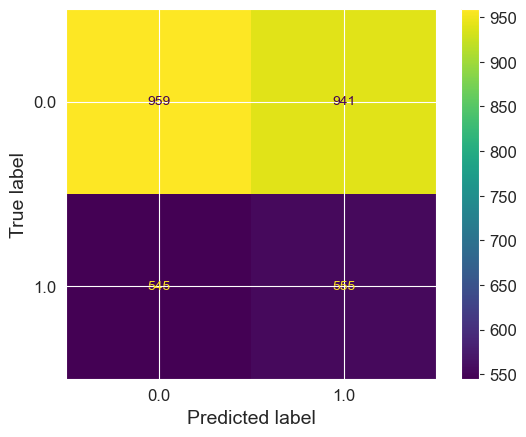

In [214]:
cm = confusion_matrix(y_test, y_pred, labels = svm_model.classes_)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=svm_model.classes_)
cm_disp.plot()

In [215]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.50      0.56      1900
           1       0.37      0.50      0.43      1100

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.54      0.50      0.51      3000



## Preliminary Naive Bayes Model

In [267]:
# Function to extract features from tokens
def extract_features(tokens):
    return {word: True for word in tokens}
    
# Prepare feature sets for training
feature_sets = [(extract_features(row['feature_words']), row['Sex']) for index, row in resampled_df.iterrows()]

# Train Naive Bayes classifier
classifier = NaiveBayesClassifier.train(feature_sets)

# Print the most informative features
classifier.show_most_informative_features(30)

Most Informative Features
                    2010 = True              0.0 : 1.0    =     10.3 : 1.0
               occasions = True              1.0 : 0.0    =      8.3 : 1.0
                   break = True              1.0 : 0.0    =      7.7 : 1.0
          depressionthis = True              1.0 : 0.0    =      7.7 : 1.0
                 fibroid = True              0.0 : 1.0    =      7.7 : 1.0
                ingested = True              1.0 : 0.0    =      7.7 : 1.0
             intensities = True              0.0 : 1.0    =      7.0 : 1.0
                 missing = True              0.0 : 1.0    =      7.0 : 1.0
         polyunsaturated = True              0.0 : 1.0    =      7.0 : 1.0
                  twoarm = True              1.0 : 0.0    =      7.0 : 1.0
                    ward = True              0.0 : 1.0    =      7.0 : 1.0
         atherosclerosis = True              0.0 : 1.0    =      6.3 : 1.0
               encourage = True              0.0 : 1.0    =      6.3 : 1.0

## Apply preprocessing to test set and get predictions

In [276]:
# Prepare feature sets for testing
test_feature_sets = [extract_features(row['ProcessedSummary']) for index, row in X_test.iterrows()]

# Get predictions for each feature set
y_pred_nb = [classifier.classify(features) for features in test_feature_sets]

In [277]:
len(y_test), len(y_pred_nb)

(3000, 3000)

In [281]:
# Prepare lists to store probabilities and labels
probs = []
labels = []

# Classify and get probabilities for each entry
for i in test_feature_sets:
    prob_dist = classifier.prob_classify(i)
    estimated_sex = prob_dist.max()
    prob = prob_dist.prob(estimated_sex)
    probs.append(prob)
    labels.append(estimated_sex)

In [286]:
# Add probability metrics to dataframe
X_test['probs'] = probs
X_test['est_labels'] = labels

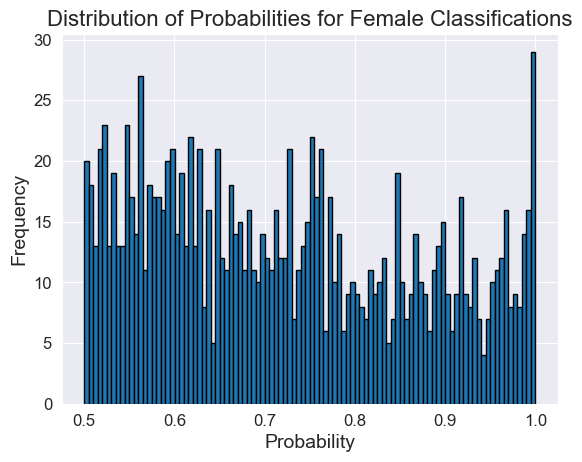

In [284]:
# Distributio of probabilities for Female
female_probs = X_test[X_test['est_labels'] == 0]['probs']

# Plot the histogram
plt.hist(female_probs, bins=100, edgecolor='black')
plt.title('Distribution of Probabilities for Female Classifications')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

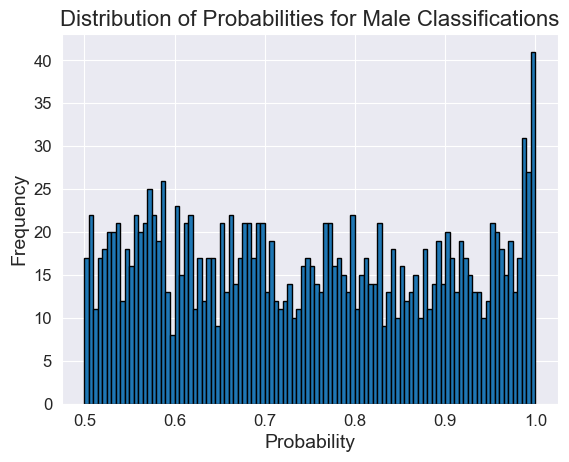

In [285]:
# Distributio of probabilities for Female
male_probs = X_test[X_test['est_labels'] == 1]['probs']

# Plot the histogram
plt.hist(male_probs, bins=100, edgecolor='black')
plt.title('Distribution of Probabilities for Male Classifications')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

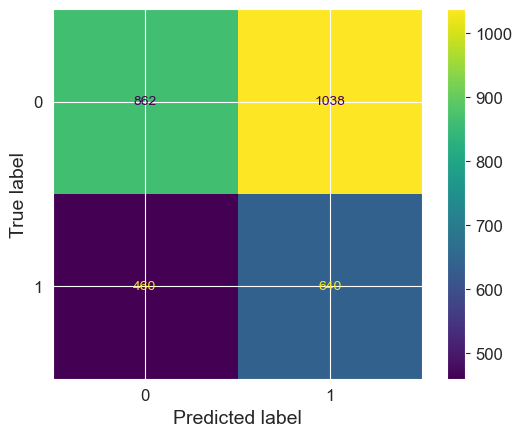

In [278]:
sex = [0,1]
# Confusion matrix for performance
conf_mat = confusion_matrix(y_test, y_pred_nb, labels=sex)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=sex)
conf_mat_disp.plot()
plt.show()

In [280]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.65      0.45      0.54      1900
           1       0.38      0.58      0.46      1100

    accuracy                           0.50      3000
   macro avg       0.52      0.52      0.50      3000
weighted avg       0.55      0.50      0.51      3000

